In [ ]:
# Install core scientific stack, ML, Hugging Face, and Jupyter tools
!python -m pip install --upgrade pip

!pip install \
    numpy \
    pandas \
    matplotlib \
    scikit-learn \
    datasets \
    transformers \
    accelerate \
    torch \
    notebook \
    jupyterlab


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
print("torch.version.cuda:", torch.version.cuda)
print("torch.cuda.is_available():", torch.cuda.is_available())
print("device_count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU 0:", torch.cuda.get_device_name(0))

torch.version.cuda: 12.4
torch.cuda.is_available(): True
device_count: 1
GPU 0: NVIDIA GeForce RTX 3080 Ti


In [3]:
import os, torch

print("torch.version.cuda =", torch.version.cuda)
print("CUDA_VISIBLE_DEVICES =", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("torch.cuda.is_available() =", torch.cuda.is_available())
print("device_count =", torch.cuda.device_count())

if torch.cuda.is_available():
    print("device 0 name:", torch.cuda.get_device_name(0))

torch.version.cuda = 12.4
CUDA_VISIBLE_DEVICES = None
torch.cuda.is_available() = True
device_count = 1
device 0 name: NVIDIA GeForce RTX 3080 Ti


In [ ]:
#package
import sys

import numpy as np
import pandas as pd
import matplotlib
import sklearn
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

print("Python version:", sys.version)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)
print("torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

print("datasets imported from:", load_dataset.__module__)
print("transformers imported from:", AutoTokenizer.__module__.split('.')[0])

C:\Users\24644\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version: 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
numpy: 2.3.3
pandas: 2.3.3
matplotlib: 3.10.7
scikit-learn: 1.7.2
torch: 2.6.0+cu124
CUDA available: True
datasets imported from: datasets.load
transformers imported from: transformers


In [5]:
# Cell 0: core imports & config

import os
import random
import numpy as np
import pandas as pd

from datasets import load_dataset

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [6]:
# Cell 1: load the English Amazon reviews dataset (5-star labels)

dataset_id = "SetFit/amazon_reviews_multi_en"

# This automatically gives you train / validation / test
raw_ds = load_dataset(dataset_id)

print(raw_ds)          # shows splits and sizes
print(raw_ds["train"][0])  # show one example row


DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 5000
    })
})
{'id': 'en_0964290', 'text': "Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process.", 'label':

In [7]:
# Inspect label mapping
train_labels = raw_ds["train"].to_pandas()[["label", "label_text"]]
print(train_labels.drop_duplicates().sort_values("label"))


        label label_text
0           0          0
40000       1          1
80000       2          2
120000      3          3
160000      4          4


In [ ]:
# Starting point: raw_ds from SetFit/amazon_reviews_multi_en
# raw_ds has splits: train / validation / test
# columns: ['id', 'text', 'label', 'label_text']

def add_fields(example):
    # star rating 1..5 from label 0..4
    star = int(example["label"]) + 1

    # 3-class sentiment from star:
    # 1–2 -> 0 (negative), 3 -> 1 (neutral), 4–5 -> 2 (positive)
    if star <= 2:
        sentiment = 0
    elif star == 3:
        sentiment = 1
    else:
        sentiment = 2

    text = example["text"] or ""
    text_len = len(text.split())

    example["star"] = star
    example["sentiment"] = sentiment
    example["text_len"] = text_len
    return example

ds = raw_ds.map(add_fields)

print(ds)
print(ds["train"][0])

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'star', 'sentiment', 'text_len'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'star', 'sentiment', 'text_len'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'star', 'sentiment', 'text_len'],
        num_rows: 5000
    })
})
{'id': 'en_0964290', 'text': "Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder

In [9]:
# Cell 2.2 – Datasets for the two tasks (adds 'labels' column)

# 5-class rating task: labels = original 0..4
def add_labels_rating(example):
    example["labels"] = int(example["label"])
    return example

ds_rating5 = ds.map(add_labels_rating)

# 3-class sentiment task: labels = sentiment 0..2
def add_labels_sentiment(example):
    example["labels"] = int(example["sentiment"])
    return example

ds_sent3 = ds.map(add_labels_sentiment)

print("Rating task sample:", ds_rating5["train"][0])
print("Sentiment task sample:", ds_sent3["train"][0])


Rating task sample: {'id': 'en_0964290', 'text': "Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process.", 'label': 0, 'label_text': '0', 'star': 1, 'sentiment': 0, 'text_len': 112, 'labels': 0}
Sentiment task sample: {'id': 'en_0964290', 'text': "Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing

In [10]:
#!pip install seaborn

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a subset of train for faster plotting
max_rows_for_eda = 50_000

train_for_eda = (
    ds["train"]
    .shuffle(seed=RANDOM_SEED)          # <– randomize order
    .select(range(min(max_rows_for_eda, ds["train"].num_rows)))
)

train_df = train_for_eda.to_pandas()


print("Rows used for EDA:", len(train_df))

print("\nStar distribution:")
print(train_df["star"].value_counts(normalize=True).sort_index())

print("\nSentiment distribution (0=neg, 1=neutral, 2=pos):")
print(train_df["sentiment"].value_counts(normalize=True).sort_index())

print("\nText length summary:")
print(train_df["text_len"].describe())


Rows used for EDA: 50000

Star distribution:
star
1    0.19762
2    0.19748
3    0.20344
4    0.20078
5    0.20068
Name: proportion, dtype: float64

Sentiment distribution (0=neg, 1=neutral, 2=pos):
sentiment
0    0.39510
1    0.20344
2    0.40146
Name: proportion, dtype: float64

Text length summary:
count    50000.00000
mean        34.08410
std         34.32686
min          1.00000
25%         13.00000
50%         24.00000
75%         44.00000
max        713.00000
Name: text_len, dtype: float64


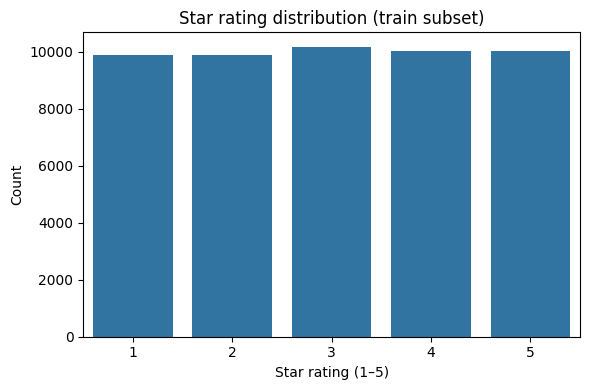

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x="star")
plt.xlabel("Star rating (1–5)")
plt.ylabel("Count")
plt.title("Star rating distribution (train subset)")
plt.tight_layout()
plt.savefig("fig_star_distribution.png", dpi=150, bbox_inches="tight")
plt.show()


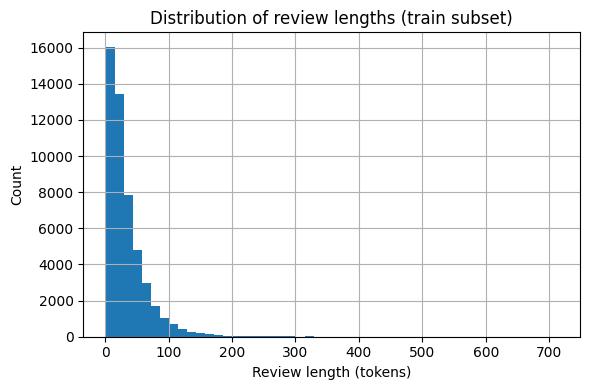

In [13]:
plt.figure(figsize=(6, 4))
train_df["text_len"].hist(bins=50)
plt.xlabel("Review length (tokens)")
plt.ylabel("Count")
plt.title("Distribution of review lengths (train subset)")
plt.tight_layout()
plt.savefig("fig_review_length_distribution.png", dpi=150, bbox_inches="tight")
plt.show()


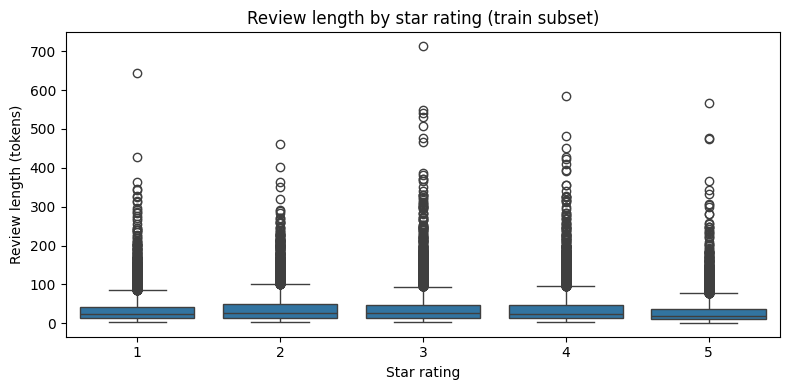

In [14]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=train_df, x="star", y="text_len")
plt.xlabel("Star rating")
plt.ylabel("Review length (tokens)")
plt.title("Review length by star rating (train subset)")
plt.tight_layout()
plt.savefig("fig_length_vs_star.png", dpi=150, bbox_inches="tight")
plt.show()


In [ ]:
#build two scikit-learn models:
#5-class rating: predict label (0–4 → stars 1–5).
#3-class sentiment: predict sentiment (0=neg,1=neutral,2=pos).
#3.1 Convert full splits to DataFrames
from sklearn.model_selection import train_test_split

# Full splits
train_df_full = ds["train"].to_pandas()
val_df_full   = ds["validation"].to_pandas()
test_df_full  = ds["test"].to_pandas()

print("Full sizes:", len(train_df_full), len(val_df_full), len(test_df_full))

#  subsample train to speed up TF–IDF + LR
max_train_samples = 50_000

if len(train_df_full) > max_train_samples:
    train_df = train_df_full.sample(
        n=max_train_samples, random_state=RANDOM_SEED
    ).reset_index(drop=True)
else:
    train_df = train_df_full.copy().reset_index(drop=True)

print("Train subset size:", len(train_df))


Full sizes: 200000 5000 5000
Train subset size: 50000


In [16]:
#Helper for evaluating models
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, X, y, split_name):
    preds = model.predict(X)
    acc = accuracy_score(y, preds)
    print(f"\n=== {split_name} accuracy: {acc:.3f} ===")
    print(classification_report(y, preds))
    return acc


In [17]:
#5-class rating baseline (TF–IDF + Logistic Regression)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Features
X_train = train_df["text"].values
X_val   = val_df_full["text"].values
X_test  = test_df_full["text"].values

# Targets: 0..4 (same as label)
y_train_rating = train_df["label"].values
y_val_rating   = val_df_full["label"].values
y_test_rating  = test_df_full["label"].values

tfidf_logreg_5 = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=50_000,
        ngram_range=(1, 2),
        min_df=2
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        multi_class="multinomial",
        solver="lbfgs"
    ))
])

print("Training 5-class rating baseline (TF-IDF + Logistic Regression)...")
tfidf_logreg_5.fit(X_train, y_train_rating)

acc_val_5  = evaluate_model(tfidf_logreg_5, X_val,  y_val_rating,  "Validation (5-class)")
acc_test_5 = evaluate_model(tfidf_logreg_5, X_test, y_test_rating, "Test (5-class)")

baseline_5_results = {
    "val_accuracy": acc_val_5,
    "test_accuracy": acc_test_5,
}
baseline_5_results


Training 5-class rating baseline (TF-IDF + Logistic Regression)...


C:\Users\24644\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Validation (5-class) accuracy: 0.527 ===
              precision    recall  f1-score   support

           0       0.61      0.66      0.63      1000
           1       0.41      0.40      0.40      1000
           2       0.41      0.39      0.40      1000
           3       0.51      0.43      0.47      1000
           4       0.66      0.76      0.71      1000

    accuracy                           0.53      5000
   macro avg       0.52      0.53      0.52      5000
weighted avg       0.52      0.53      0.52      5000


=== Test (5-class) accuracy: 0.517 ===
              precision    recall  f1-score   support

           0       0.60      0.66      0.63      1000
           1       0.40      0.37      0.38      1000
           2       0.39      0.38      0.39      1000
           3       0.51      0.46      0.48      1000
           4       0.65      0.73      0.69      1000

    accuracy                           0.52      5000
   macro avg       0.51      0.52      0.51  

{'val_accuracy': 0.5274, 'test_accuracy': 0.5174}

In [18]:
#3-class sentiment baseline (TF–IDF + Logistic Regression)
# Targets: 0=negative, 1=neutral, 2=positive
y_train_sent = train_df["sentiment"].values
y_val_sent   = val_df_full["sentiment"].values
y_test_sent  = test_df_full["sentiment"].values

tfidf_logreg_3 = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=50_000,
        ngram_range=(1, 2),
        min_df=2
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        multi_class="multinomial",
        solver="lbfgs"
    ))
])

print("Training 3-class sentiment baseline (TF-IDF + Logistic Regression)...")
tfidf_logreg_3.fit(X_train, y_train_sent)

acc_val_3  = evaluate_model(tfidf_logreg_3, X_val,  y_val_sent,  "Validation (3-class)")
acc_test_3 = evaluate_model(tfidf_logreg_3, X_test, y_test_sent, "Test (3-class)")

baseline_3_results = {
    "val_accuracy": acc_val_3,
    "test_accuracy": acc_test_3,
}
baseline_3_results


Training 3-class sentiment baseline (TF-IDF + Logistic Regression)...


C:\Users\24644\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Validation (3-class) accuracy: 0.715 ===
              precision    recall  f1-score   support

           0       0.73      0.83      0.78      2000
           1       0.42      0.24      0.31      1000
           2       0.78      0.84      0.81      2000

    accuracy                           0.72      5000
   macro avg       0.64      0.64      0.63      5000
weighted avg       0.69      0.72      0.70      5000


=== Test (3-class) accuracy: 0.716 ===
              precision    recall  f1-score   support

           0       0.73      0.83      0.77      2000
           1       0.43      0.24      0.31      1000
           2       0.78      0.84      0.81      2000

    accuracy                           0.72      5000
   macro avg       0.65      0.64      0.63      5000
weighted avg       0.69      0.72      0.70      5000



{'val_accuracy': 0.7154, 'test_accuracy': 0.7158}

In [19]:
# layer: PyTorch MLP
#4.1Build TF–IDF features for MLP (smaller subset)
import torch
from sklearn.feature_extraction.text import TfidfVectorizer

# Choose a smaller train subset for the MLP to avoid memory issues
max_train_samples_mlp = 30_000  # reduce if you run out of RAM

if len(train_df_full) > max_train_samples_mlp:
    train_df_mlp = train_df_full.sample(
        n=max_train_samples_mlp, random_state=RANDOM_SEED
    ).reset_index(drop=True)
else:
    train_df_mlp = train_df_full.copy().reset_index(drop=True)

print("Train size for MLP:", len(train_df_mlp))

# TF–IDF with fewer features than the baseline to keep tensors manageable
tfidf_mlp = TfidfVectorizer(
    max_features=5_000,   # adjust if you want; fewer = less memory
    ngram_range=(1, 2),
    min_df=2
)

# Fit on the MLP training subset and transform all splits
X_train_sparse = tfidf_mlp.fit_transform(train_df_mlp["text"])
X_val_sparse   = tfidf_mlp.transform(val_df_full["text"])
X_test_sparse  = tfidf_mlp.transform(test_df_full["text"])

print("Sparse shapes:",
      X_train_sparse.shape, X_val_sparse.shape, X_test_sparse.shape)

# Convert to dense float32 tensors for PyTorch
X_train_mlp = torch.from_numpy(X_train_sparse.toarray()).float()
X_val_mlp   = torch.from_numpy(X_val_sparse.toarray()).float()
X_test_mlp  = torch.from_numpy(X_test_sparse.toarray()).float()

input_dim = X_train_mlp.shape[1]
print("Input dimension for MLP:", input_dim)


Train size for MLP: 30000
Sparse shapes: (30000, 5000) (5000, 5000) (5000, 5000)
Input dimension for MLP: 5000


In [20]:
#Create label tensors (5-class rating and 3-class sentiment)
# 5-class rating labels: 0..4 (same as 'label' column)
y_train_rating_mlp = torch.from_numpy(train_df_mlp["label"].values).long()
y_val_rating_mlp   = torch.from_numpy(val_df_full["label"].values).long()
y_test_rating_mlp  = torch.from_numpy(test_df_full["label"].values).long()

# 3-class sentiment labels: 0=neg,1=neutral,2=pos
y_train_sent_mlp = torch.from_numpy(train_df_mlp["sentiment"].values).long()
y_val_sent_mlp   = torch.from_numpy(val_df_full["sentiment"].values).long()
y_test_sent_mlp  = torch.from_numpy(test_df_full["sentiment"].values).long()

print("Label shapes (rating):", y_train_rating_mlp.shape, y_val_rating_mlp.shape, y_test_rating_mlp.shape)
print("Label shapes (sent):  ", y_train_sent_mlp.shape,   y_val_sent_mlp.shape,   y_test_sent_mlp.shape)


Label shapes (rating): torch.Size([30000]) torch.Size([5000]) torch.Size([5000])
Label shapes (sent):   torch.Size([30000]) torch.Size([5000]) torch.Size([5000])


In [21]:
#Build DataLoaders for the 5-class rating task
from torch.utils.data import TensorDataset, DataLoader

batch_size = 128

train_dataset_rating = TensorDataset(X_train_mlp, y_train_rating_mlp)
val_dataset_rating   = TensorDataset(X_val_mlp,   y_val_rating_mlp)
test_dataset_rating  = TensorDataset(X_test_mlp,  y_test_rating_mlp)

train_loader_rating = DataLoader(train_dataset_rating, batch_size=batch_size, shuffle=True)
val_loader_rating   = DataLoader(val_dataset_rating,   batch_size=batch_size, shuffle=False)
test_loader_rating  = DataLoader(test_dataset_rating,  batch_size=batch_size, shuffle=False)

len(train_loader_rating), len(val_loader_rating), len(test_loader_rating)


(235, 40, 40)

In [22]:
#Define the MLP model and training loop (5-class rating)
import torch.nn as nn

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_classes_rating = 5
hidden_dim = 256

model_rating = MLPClassifier(input_dim, hidden_dim, num_classes_rating, dropout=0.5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rating.parameters(), lr=1e-3)

def evaluate_loader(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in data_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total


Using device: cuda


In [23]:
#Train and evaluate the 5-class rating MLP
num_epochs = 5  # adjust as needed

for epoch in range(1, num_epochs + 1):
    model_rating.train()
    running_loss = 0.0
    for xb, yb in train_loader_rating:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model_rating(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)

    train_loss = running_loss / len(train_dataset_rating)
    val_acc = evaluate_loader(model_rating, val_loader_rating)

    print(f"Epoch {epoch:02d} | train loss: {train_loss:.4f} | val acc: {val_acc:.3f}")

test_acc_rating = evaluate_loader(model_rating, test_loader_rating)
print(f"\nTest accuracy (MLP, 5-class rating): {test_acc_rating:.3f}")


Epoch 01 | train loss: 1.3124 | val acc: 0.510
Epoch 02 | train loss: 1.0418 | val acc: 0.518
Epoch 03 | train loss: 0.9625 | val acc: 0.514
Epoch 04 | train loss: 0.9036 | val acc: 0.514
Epoch 05 | train loss: 0.8522 | val acc: 0.507

Test accuracy (MLP, 5-class rating): 0.502


In [24]:
#Reuse features for a 3-class sentiment MLP
# New datasets with sentiment labels
train_dataset_sent = TensorDataset(X_train_mlp, y_train_sent_mlp)
val_dataset_sent   = TensorDataset(X_val_mlp,   y_val_sent_mlp)
test_dataset_sent  = TensorDataset(X_test_mlp,  y_test_sent_mlp)

train_loader_sent = DataLoader(train_dataset_sent, batch_size=batch_size, shuffle=True)
val_loader_sent   = DataLoader(val_dataset_sent,   batch_size=batch_size, shuffle=False)
test_loader_sent  = DataLoader(test_dataset_sent,  batch_size=batch_size, shuffle=False)

num_classes_sent = 3
model_sent = MLPClassifier(input_dim, hidden_dim, num_classes_sent, dropout=0.5).to(device)

criterion_sent = nn.CrossEntropyLoss()
optimizer_sent = torch.optim.Adam(model_sent.parameters(), lr=1e-3)

num_epochs_sent = 5

for epoch in range(1, num_epochs_sent + 1):
    model_sent.train()
    running_loss = 0.0
    for xb, yb in train_loader_sent:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer_sent.zero_grad()
        logits = model_sent(xb)
        loss = criterion_sent(logits, yb)
        loss.backward()
        optimizer_sent.step()

        running_loss += loss.item() * xb.size(0)

    train_loss = running_loss / len(train_dataset_sent)
    val_acc = evaluate_loader(model_sent, val_loader_sent)

    print(f"[Sentiment] Epoch {epoch:02d} | train loss: {train_loss:.4f} | val acc: {val_acc:.3f}")

test_acc_sent = evaluate_loader(model_sent, test_loader_sent)
print(f"\nTest accuracy (MLP, 3-class sentiment): {test_acc_sent:.3f}")


[Sentiment] Epoch 01 | train loss: 0.7998 | val acc: 0.707
[Sentiment] Epoch 02 | train loss: 0.6044 | val acc: 0.708
[Sentiment] Epoch 03 | train loss: 0.5502 | val acc: 0.702
[Sentiment] Epoch 04 | train loss: 0.5101 | val acc: 0.697
[Sentiment] Epoch 05 | train loss: 0.4691 | val acc: 0.691

Test accuracy (MLP, 3-class sentiment): 0.698


In [25]:
#Transformer fine-tuning
#5.1 Choose task and prepare HF datasets
from datasets import DatasetDict

# We already built ds_rating5 and ds_sent3 earlier, each with:
# - "text"
# - "labels" (0..4 for rating, 0..2 for sentiment)

# Choose which task to fine-tune on: "rating5" or "sentiment3"
task = "sentiment3"     # change to "sentiment3" for the other run

if task == "rating5":
    hf_ds = ds_rating5
    num_labels = 5
    label_names = ["1", "2", "3", "4", "5"]
elif task == "sentiment3":
    hf_ds = ds_sent3
    num_labels = 3
    label_names = ["negative", "neutral", "positive"]
else:
    raise ValueError("task must be 'rating5' or 'sentiment3'")

id2label = {i: name for i, name in enumerate(label_names)}
label2id = {name: i for i, name in id2label.items()}

print(hf_ds)
print("Example:", hf_ds["train"][0])
print("Task:", task, "| num_labels:", num_labels)


DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'star', 'sentiment', 'text_len', 'labels'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'star', 'sentiment', 'text_len', 'labels'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'star', 'sentiment', 'text_len', 'labels'],
        num_rows: 5000
    })
})
Example: {'id': 'en_0964290', 'text': "Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be he

In [26]:
#Tokenizer, subsampling, and tokenization
from transformers import AutoTokenizer

model_checkpoint = "LiYuan/amazon-review-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Subsample training set for speed if needed
max_train_samples_bert = 50_000   # lower this if you're on CPU
train_ds_full = hf_ds["train"].shuffle(seed=RANDOM_SEED)

if len(train_ds_full) > max_train_samples_bert:
    train_ds = train_ds_full.select(range(max_train_samples_bert))
else:
    train_ds = train_ds_full

eval_ds = hf_ds["validation"]
test_ds = hf_ds["test"]

print("Train size (BERT):", len(train_ds), "Eval:", len(eval_ds), "Test:", len(test_ds))

def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=256,
    )

tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_eval  = eval_ds.map(tokenize_function,  batched=True)
tokenized_test  = test_ds.map(tokenize_function,  batched=True)

# Keep only what the model needs: input_ids, attention_mask, labels
keep_cols = ["input_ids", "attention_mask", "labels"]

def keep_necessary_columns(ds_tok):
    cols_to_drop = [c for c in ds_tok.column_names if c not in keep_cols]
    return ds_tok.remove_columns(cols_to_drop)

tokenized_train = keep_necessary_columns(tokenized_train)
tokenized_eval  = keep_necessary_columns(tokenized_eval)
tokenized_test  = keep_necessary_columns(tokenized_test)

print(tokenized_train)
print(tokenized_train[0])


Train size (BERT): 50000 Eval: 5000 Test: 5000
Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 50000
})
{'labels': 1, 'input_ids': [101, 124, 14548, 12175, 11269, 10320, 10497, 27489, 94246, 10107, 10146, 17424, 10104, 10103, 38863, 20419, 119, 10160, 16331, 10103, 12985, 96494, 10902, 14217, 10125, 10103, 13175, 27101, 10108, 10103, 59915, 10203, 151, 15517, 10197, 10139, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [27]:
#DataCollator, metrics, model, TrainingArguments, Trainer
from transformers import (
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
from sklearn.metrics import accuracy_score
import numpy as np
import torch

# Data collator and metrics
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # <-- key line
)
model.to(device)

output_dir = f"outputs_{task}"

# Minimal TrainingArguments that work with older transformers versions
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)



Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at LiYuan/amazon-review-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\24644\AppData\Local\Temp\ipykernel_12344\577347526.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
#Train and evaluate (validation + test)

train_result = trainer.train()
print("Training done.")

# Evaluate on validation and test
metrics_val = trainer.evaluate(tokenized_eval)
print("\nValidation metrics:", metrics_val)

metrics_test = trainer.evaluate(tokenized_test)
print("\nTest metrics:", metrics_test)

import json, os
metrics_path = os.path.join(output_dir, f"{task}_metrics.json")
with open(metrics_path, "w") as f:
    json.dump({"validation": metrics_val, "test": metrics_test}, f, indent=2)
print("Metrics saved to:", metrics_path)


Step,Training Loss
500,0.605300
1000,0.593600
1500,0.585900
2000,0.567400
2500,0.573700
3000,0.561300
3500,0.509400
4000,0.466600
4500,0.486400
5000,0.482700


Training done.



Validation metrics: {'eval_loss': 0.6354519128799438, 'eval_accuracy': 0.7594, 'eval_runtime': 10.5815, 'eval_samples_per_second': 472.524, 'eval_steps_per_second': 29.58, 'epoch': 3.0}

Test metrics: {'eval_loss': 0.6191021800041199, 'eval_accuracy': 0.7612, 'eval_runtime': 10.6906, 'eval_samples_per_second': 467.702, 'eval_steps_per_second': 29.278, 'epoch': 3.0}
Metrics saved to: outputs_sentiment3\sentiment3_metrics.json


In [ ]:
#Transformer fine-tuning
#5.1 Choose task and prepare HF datasets
from datasets import DatasetDict

# We already built ds_rating5 and ds_sent3 earlier, each with:
# - "text"
# - "labels" (0..4 for rating, 0..2 for sentiment)

# Choose which task to fine-tune on: "rating5" or "sentiment3"
task = "rating5"     # change to "sentiment3" for the other run

if task == "rating5":
    hf_ds = ds_rating5
    num_labels = 5
    label_names = ["1", "2", "3", "4", "5"]
elif task == "sentiment3":
    hf_ds = ds_sent3
    num_labels = 3
    label_names = ["negative", "neutral", "positive"]
else:
    raise ValueError("task must be 'rating5' or 'sentiment3'")

id2label = {i: name for i, name in enumerate(label_names)}
label2id = {name: i for i, name in id2label.items()}

print(hf_ds)
print("Example:", hf_ds["train"][0])
print("Task:", task, "| num_labels:", num_labels)

#Tokenizer, subsampling, and tokenization
from transformers import AutoTokenizer

model_checkpoint = "LiYuan/amazon-review-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Subsample training set for speed if needed
max_train_samples_bert = 50_000   # lower this if you're on CPU
train_ds_full = hf_ds["train"].shuffle(seed=RANDOM_SEED)

if len(train_ds_full) > max_train_samples_bert:
    train_ds = train_ds_full.select(range(max_train_samples_bert))
else:
    train_ds = train_ds_full

eval_ds = hf_ds["validation"]
test_ds = hf_ds["test"]

print("Train size (BERT):", len(train_ds), "Eval:", len(eval_ds), "Test:", len(test_ds))

def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=256,
    )

tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_eval  = eval_ds.map(tokenize_function,  batched=True)
tokenized_test  = test_ds.map(tokenize_function,  batched=True)

# Keep only what the model needs: input_ids, attention_mask, labels
keep_cols = ["input_ids", "attention_mask", "labels"]

def keep_necessary_columns(ds_tok):
    cols_to_drop = [c for c in ds_tok.column_names if c not in keep_cols]
    return ds_tok.remove_columns(cols_to_drop)

tokenized_train = keep_necessary_columns(tokenized_train)
tokenized_eval  = keep_necessary_columns(tokenized_eval)
tokenized_test  = keep_necessary_columns(tokenized_test)


DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'star', 'sentiment', 'text_len', 'labels'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'star', 'sentiment', 'text_len', 'labels'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text', 'star', 'sentiment', 'text_len', 'labels'],
        num_rows: 5000
    })
})
Example: {'id': 'en_0964290', 'text': "Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be he

In [30]:
from transformers import (
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
from sklearn.metrics import accuracy_score
import numpy as np
import torch

#Data collator and metrics
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    # safe even if num_labels == 5; needed when num_labels changes
    ignore_mismatched_sizes=True,
)
model.to(device)

outputdir = f"outputs{task}"

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Using device: cuda


C:\Users\24644\AppData\Local\Temp\ipykernel_12344\4267808513.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [31]:
print(tokenized_train)
print(tokenized_train[0])

#Train and evaluate (validation + test)

train_result = trainer.train()
print("Training done.")

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 50000
})
{'labels': 2, 'input_ids': [101, 124, 14548, 12175, 11269, 10320, 10497, 27489, 94246, 10107, 10146, 17424, 10104, 10103, 38863, 20419, 119, 10160, 16331, 10103, 12985, 96494, 10902, 14217, 10125, 10103, 13175, 27101, 10108, 10103, 59915, 10203, 151, 15517, 10197, 10139, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Step,Training Loss
500,1.015800
1000,1.010400
1500,1.002800
2000,0.976600
2500,0.991600
3000,0.966400
3500,0.905300
4000,0.855400
4500,0.874000
5000,0.869600


Training done.


In [32]:
# Evaluate on validation and test
metrics_val = trainer.evaluate(tokenized_eval)
print("\nValidation metrics:", metrics_val)

metrics_test = trainer.evaluate(tokenized_test)
print("\nTest metrics:", metrics_test)

import json, os

# IMPORTANT: compute output_dir from *current* task
output_dir = f"outputs_{task}"
os.makedirs(output_dir, exist_ok=True)

metrics_path = os.path.join(output_dir, f"{task}_metrics.json")
with open(metrics_path, "w") as f:
    json.dump({"validation": metrics_val, "test": metrics_test}, f, indent=2)
print("Metrics saved to:", metrics_path)



Validation metrics: {'eval_loss': 1.0526493787765503, 'eval_accuracy': 0.5802, 'eval_runtime': 10.5684, 'eval_samples_per_second': 473.106, 'eval_steps_per_second': 29.616, 'epoch': 3.0}

Test metrics: {'eval_loss': 1.0228790044784546, 'eval_accuracy': 0.5836, 'eval_runtime': 10.167, 'eval_samples_per_second': 491.785, 'eval_steps_per_second': 30.786, 'epoch': 3.0}
Metrics saved to: outputs_rating5\rating5_metrics.json


In [33]:
#6.1 Load BERT test accuracies from the saved JSON files
import json
import os

def load_bert_test_accuracy(task_name: str) -> float:
    """
    Load test accuracy for the given task from the JSON saved in Cell 5.4.
    task_name: "rating5" or "sentiment3"
    """
    metrics_path = os.path.join(f"outputs_{task_name}", f"{task_name}_metrics.json")
    with open(metrics_path, "r") as f:
        metrics = json.load(f)
    test_metrics = metrics["test"]
    # Newer Trainer uses 'eval_accuracy'; older ones may just use 'accuracy'
    acc = test_metrics.get("eval_accuracy", test_metrics.get("accuracy"))
    return float(acc)

bert_test_acc_5 = load_bert_test_accuracy("rating5")
bert_test_acc_3 = load_bert_test_accuracy("sentiment3")

print("Transformer test accuracy (5-class rating):   ", bert_test_acc_5)
print("Transformer test accuracy (3-class sentiment):", bert_test_acc_3)


Transformer test accuracy (5-class rating):    0.5836
Transformer test accuracy (3-class sentiment): 0.7612


In [34]:
#Build summary tables of model performance
import pandas as pd

# 5-class rating summary
summary_5 = pd.DataFrame({
    "model": [
        "TF-IDF + Logistic Regression",
        "MLP (TF-IDF features)",
        "Transformer (BERT fine-tuned)",
    ],
    "test_accuracy": [
        float(baseline_5_results["test_accuracy"]),
        float(test_acc_rating),
        float(bert_test_acc_5),
    ],
})

# 3-class sentiment summary
summary_3 = pd.DataFrame({
    "model": [
        "TF-IDF + Logistic Regression",
        "MLP (TF-IDF features)",
        "Transformer (BERT fine-tuned)",
    ],
    "test_accuracy": [
        float(baseline_3_results["test_accuracy"]),
        float(test_acc_sent),
        float(bert_test_acc_3),
    ],
})

print("5-class rating task:\n", summary_5, "\n")
print("3-class sentiment task:\n", summary_3)


5-class rating task:
                            model  test_accuracy
0   TF-IDF + Logistic Regression         0.5174
1          MLP (TF-IDF features)         0.5020
2  Transformer (BERT fine-tuned)         0.5836 

3-class sentiment task:
                            model  test_accuracy
0   TF-IDF + Logistic Regression         0.7158
1          MLP (TF-IDF features)         0.6978
2  Transformer (BERT fine-tuned)         0.7612


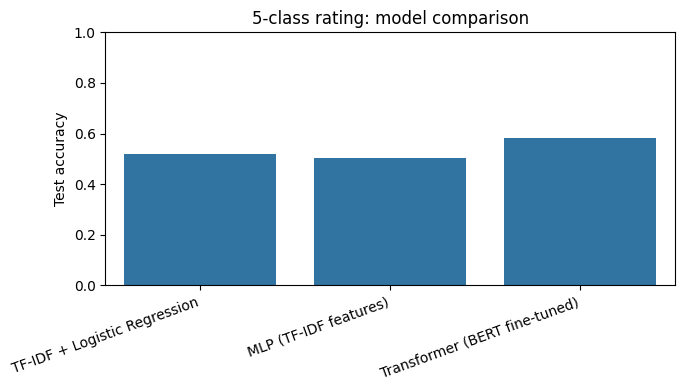

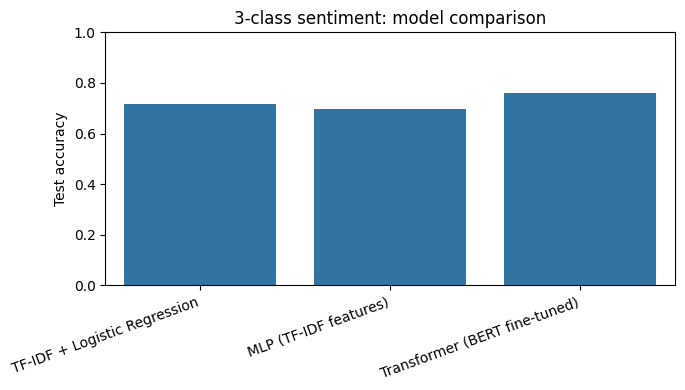

In [35]:
#Bar plots for model comparison (figures for the report)
import matplotlib.pyplot as plt
import seaborn as sns

# 5-class rating plot
plt.figure(figsize=(7, 4))
sns.barplot(data=summary_5, x="model", y="test_accuracy")
plt.ylim(0.0, 1.0)
plt.ylabel("Test accuracy")
plt.xlabel("")
plt.title("5-class rating: model comparison")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig("fig_model_comparison_rating5.png", dpi=150, bbox_inches="tight")
plt.show()

# 3-class sentiment plot
plt.figure(figsize=(7, 4))
sns.barplot(data=summary_3, x="model", y="test_accuracy")
plt.ylim(0.0, 1.0)
plt.ylabel("Test accuracy")
plt.xlabel("")
plt.title("3-class sentiment: model comparison")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.savefig("fig_model_comparison_sentiment3.png", dpi=150, bbox_inches="tight")
plt.show()
